#### put dataset in google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !unzip "/content/drive/MyDrive/2021_Olympics.zip" -d "/content/drive/MyDrive"

#### import libraries

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import pylab as p
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix

In [4]:
!pip install openpyxl==3.0.9

#### read excel files of dataset

In [5]:
file_names = ["Athletes.xlsx","Coaches.xlsx","EntriesGender.xlsx", "Medals.xlsx","Teams.xlsx"]
path_to_dataset = "/content/drive/MyDrive/2021_Olympics/"
athletes_df = pd.read_excel(path_to_dataset+file_names[0])
coaches_df = pd.read_excel(path_to_dataset+file_names[1])
entries_gender_df = pd.read_excel(path_to_dataset+file_names[2])
medals_df = pd.read_excel(path_to_dataset+file_names[3])
teams_df = pd.read_excel(path_to_dataset+file_names[4])

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [6]:
athletes_df.head(), coaches_df.head(), entries_gender_df.head(), medals_df.head(), teams_df.head()

(                Name     NOC           Discipline
 0    AALERUD Katrine  Norway         Cycling Road
 1        ABAD Nestor   Spain  Artistic Gymnastics
 2  ABAGNALE Giovanni   Italy               Rowing
 3     ABALDE Alberto   Spain           Basketball
 4      ABALDE Tamara   Spain           Basketball,
               Name            NOC  Discipline Event
 0  ABDELMAGID Wael          Egypt    Football   NaN
 1        ABE Junya          Japan  Volleyball   NaN
 2    ABE Katsuhiko          Japan  Basketball   NaN
 3     ADAMA Cherif  Côte d'Ivoire    Football   NaN
 4       AGEBA Yuya          Japan  Volleyball   NaN,
             Discipline  Female  Male  Total
 0       3x3 Basketball      32    32     64
 1              Archery      64    64    128
 2  Artistic Gymnastics      98    98    196
 3    Artistic Swimming     105     0    105
 4            Athletics     969  1072   2041,
    Rank                    Team/NOC  Gold  Silver  Bronze  Total  Rank by Total
 0     1    United Sta

In [7]:
athletes_df.shape, coaches_df.shape, entries_gender_df.shape, medals_df.shape, teams_df.shape

((11085, 3), (394, 4), (46, 4), (93, 7), (743, 4))

#### convert nominal values to numeric values

In [8]:
def convert_nominal_to_numeric(dataframe):
  for column_name in dataframe.keys():
    if dataframe[column_name].dtype == np.object:
      dataframe[column_name+"_numeric"] = pd.factorize(dataframe[column_name])[0]
      # print("value count of column '"+column_name+"': ", dataframe[column_name].value_counts())
      # print("value count of column '"+column_name+"_numeric': ", dataframe[column_name+"_numeric"].value_counts())
  return dataframe

In [9]:
athletes_df = convert_nominal_to_numeric(athletes_df)
coaches_df = convert_nominal_to_numeric(coaches_df)
entries_gender_df = convert_nominal_to_numeric(entries_gender_df)
medals_df = convert_nominal_to_numeric(medals_df)
teams_df = convert_nominal_to_numeric(teams_df)

In [10]:
def count_of_unique_values(dataframe):
  print("column_name", "number_of_unique_values")
  for column_name in dataframe.keys():
    print(column_name ,len(dataframe[column_name].unique()))

In [11]:
count_of_unique_values(athletes_df)
athletes_df.head()

column_name number_of_unique_values
Name 11062
NOC 206
Discipline 46
Name_numeric 11062
NOC_numeric 206
Discipline_numeric 46


,Name,NOC,Discipline,Name_numeric,NOC_numeric,Discipline_numeric
0,AALERUD Katrine,Norway,Cycling Road,0,0,0
1,ABAD Nestor,Spain,Artistic Gymnastics,1,1,1
2,ABAGNALE Giovanni,Italy,Rowing,2,2,2
3,ABALDE Alberto,Spain,Basketball,3,1,3
4,ABALDE Tamara,Spain,Basketball,4,1,3


In [12]:
count_of_unique_values(coaches_df)
coaches_df.head()

column_name number_of_unique_values
Name 381
NOC 61
Discipline 9
Event 7
Name_numeric 381
NOC_numeric 61
Discipline_numeric 9
Event_numeric 7


,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,NaN,0,0,0,-1
1,ABE Junya,Japan,Volleyball,NaN,1,1,1,-1
2,ABE Katsuhiko,Japan,Basketball,NaN,2,1,2,-1
3,ADAMA Cherif,Côte d'Ivoire,Football,NaN,3,2,0,-1
4,AGEBA Yuya,Japan,Volleyball,NaN,4,1,1,-1


In [13]:
count_of_unique_values(entries_gender_df)
entries_gender_df.head()

column_name number_of_unique_values
Discipline 46
Female 38
Male 41
Total 41
Discipline_numeric 46


,Discipline,Female,Male,Total,Discipline_numeric
0,3x3 Basketball,32,32,64,0
1,Archery,64,64,128,1
2,Artistic Gymnastics,98,98,196,2
3,Artistic Swimming,105,0,105,3
4,Athletics,969,1072,2041,4


In [14]:
count_of_unique_values(medals_df)
medals_df.head()

column_name number_of_unique_values
Rank 67
Team/NOC 93
Gold 14
Silver 17
Bronze 21
Total 30
Rank by Total 30
Team/NOC_numeric 93


,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric
0,1,United States of America,39,41,33,113,1,0
1,2,People's Republic of China,38,32,18,88,2,1
2,3,Japan,27,14,17,58,5,2
3,4,Great Britain,22,21,22,65,4,3
4,5,ROC,20,28,23,71,3,4


In [15]:
count_of_unique_values(teams_df)
teams_df.head()

column_name number_of_unique_values
Name 146
Discipline 20
NOC 84
Event 36
Name_numeric 146
Discipline_numeric 20
NOC_numeric 84
Event_numeric 36


,Name,Discipline,NOC,Event,Name_numeric,Discipline_numeric,NOC_numeric,Event_numeric
0,Belgium,3x3 Basketball,Belgium,Men,0,0,0,0
1,China,3x3 Basketball,People's Republic of China,Men,1,0,1,0
2,China,3x3 Basketball,People's Republic of China,Women,1,0,1,1
3,France,3x3 Basketball,France,Women,2,0,2,1
4,Italy,3x3 Basketball,Italy,Women,3,0,3,1


# 1. Dataset Analysis

## 1.1 information of attributes

In [16]:
def attributes_information(dataframe):
  info = dict()
  index = 1
  for column_name in dataframe.keys():
    info["column"+str(index)+"_name"] = column_name
    info["column"+str(index)+"_dtype"] = dataframe[column_name].dtype
    if info["column"+str(index)+"_dtype"] == np.object:
      info["column"+str(index)+"_range"] = dataframe[column_name].unique()
    elif info["column"+str(index)+"_dtype"] == np.int or info["column"+str(index)+"_dtype"] == np.float:
      info["column"+str(index)+"_range"] = [ dataframe[column_name].min(), dataframe[column_name].max()]
      info["column"+str(index)+"_mean"] = dataframe[column_name].mean()
      info["column"+str(index)+"_median"] = dataframe[column_name].median()
      info["column"+str(index)+"_mode"] = dataframe[column_name].mode()
      info["column"+str(index)+"_min"] = dataframe[column_name].min()
      info["column"+str(index)+"_max"] = dataframe[column_name].max()

    index += 1
  return info

In [17]:
athletes_attrs_info = attributes_information(athletes_df)
coaches_info = attributes_information(coaches_df)
entries_gender_attrs_info = attributes_information(entries_gender_df)
medals_attrs_info = attributes_information(medals_df)
teams_attrs_info = attributes_information(teams_df)

In [18]:
athletes_attrs_info

{'column1_dtype': dtype('O'),
 'column1_name': 'Name',
 'column1_range': array(['AALERUD Katrine', 'ABAD Nestor', 'ABAGNALE Giovanni', ...,
        'ZYKOVA Yulia', 'ZYUZINA Ekaterina', 'ZYZANSKA Sylwia'],
       dtype=object),
 'column2_dtype': dtype('O'),
 'column2_name': 'NOC',
 'column2_range': array(['Norway', 'Spain', 'Italy', 'France', 'Chile', 'Sudan',
        'Islamic Republic of Iran', 'Azerbaijan', 'Netherlands',
        'Australia', 'United States of America', 'Qatar', 'Egypt',
        'Belgium', 'Malaysia', 'Singapore', 'Maldives', 'Saudi Arabia',
        'Germany', 'Uzbekistan', 'Indonesia', 'Kazakhstan', 'Bahrain',
        'Japan', 'Ethiopia', 'Canada', 'Malta', 'Sri Lanka', 'Morocco',
        'Austria', 'Mauritania', 'ROC', 'Libya', 'Nauru', 'Switzerland',
        'South Africa', 'Guyana', 'Georgia', 'Portugal', 'Jordan',
        'Palestine', 'India', 'Cyprus', 'Nigeria', 'Tunisia', 'Mexico',
        'Colombia', 'El Salvador', 'Romania', 'Poland',
        'Federated Stat

## 1.2 show skewness of numeric data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6c6843d0>,
      dtype=object)

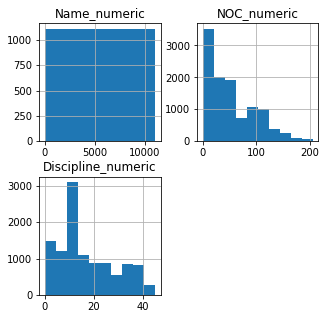

In [19]:
athletes_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6c566ed0>,
      dtype=object)

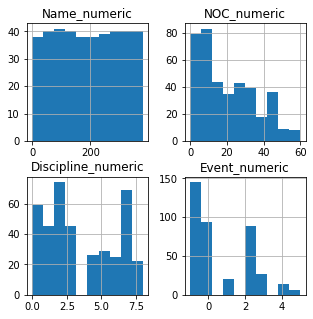

In [20]:
coaches_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6bf376d0>,
      dtype=object)

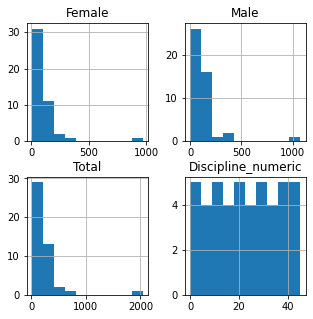

In [21]:
entries_gender_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6bd55490>,
      dtype=object)

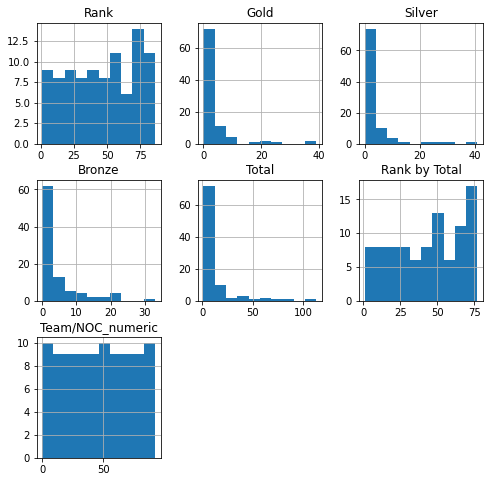

In [22]:
medals_df.hist(figsize=(8,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6b99ce90>,
      dtype=object)

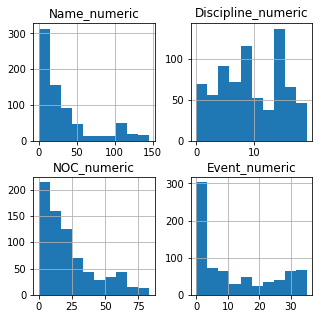

In [23]:
teams_df.hist(figsize=(5,5))

## 1.3 validity and correctness and completeness

help link: https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/

first we checked that how many value in columns don't have value. for this part we used info method of pandas lib

In [24]:
athletes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11085 entries, 0 to 11084
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                11085 non-null  object
 1   NOC                 11085 non-null  object
 2   Discipline          11085 non-null  object
 3   Name_numeric        11085 non-null  int64 
 4   NOC_numeric         11085 non-null  int64 
 5   Discipline_numeric  11085 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 519.7+ KB


In [25]:
coaches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                394 non-null    object
 1   NOC                 394 non-null    object
 2   Discipline          394 non-null    object
 3   Event               249 non-null    object
 4   Name_numeric        394 non-null    int64 
 5   NOC_numeric         394 non-null    int64 
 6   Discipline_numeric  394 non-null    int64 
 7   Event_numeric       394 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 24.8+ KB


here we checked that the columns be in correct range, for example number of females and males and etc, couldn't be negative

In [26]:
entries_gender_df.info()
print("data that is not in correct range:")
entries_gender_df.loc[(entries_gender_df["Female"] < 0) | (entries_gender_df["Male"] < 0) | (entries_gender_df["Total"] < 0) | 
                      ((entries_gender_df["Female"]+entries_gender_df["Male"]) != entries_gender_df["Total"])]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Discipline          46 non-null     object
 1   Female              46 non-null     int64 
 2   Male                46 non-null     int64 
 3   Total               46 non-null     int64 
 4   Discipline_numeric  46 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.9+ KB
data that is not in correct range:


,Discipline,Female,Male,Total,Discipline_numeric


In [27]:
medals_df.info()
print("data that is not in correct range:")
medals_df.loc[(medals_df["Rank"] < 1) | (medals_df["Gold"] < 0) | (medals_df["Silver"] < 0) |
              (medals_df["Bronze"] < 0) | (medals_df["Total"] < 0)| 
              ((medals_df["Gold"]+medals_df["Silver"]+medals_df["Bronze"]) != medals_df["Total"]) | 
              (medals_df["Rank by Total"] < 0)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rank              93 non-null     int64 
 1   Team/NOC          93 non-null     object
 2   Gold              93 non-null     int64 
 3   Silver            93 non-null     int64 
 4   Bronze            93 non-null     int64 
 5   Total             93 non-null     int64 
 6   Rank by Total     93 non-null     int64 
 7   Team/NOC_numeric  93 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 5.9+ KB
data that is not in correct range:


,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric


In [28]:
# teams_df[teams_df["Name"].isna() | teams_df["Discipline"].isna() | teams_df["NOC"].isna() | teams_df["Event"].isna()]
teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                743 non-null    object
 1   Discipline          743 non-null    object
 2   NOC                 743 non-null    object
 3   Event               743 non-null    object
 4   Name_numeric        743 non-null    int64 
 5   Discipline_numeric  743 non-null    int64 
 6   NOC_numeric         743 non-null    int64 
 7   Event_numeric       743 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 46.6+ KB


## 1.4 show histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6b8c9ed0>,
      dtype=object)

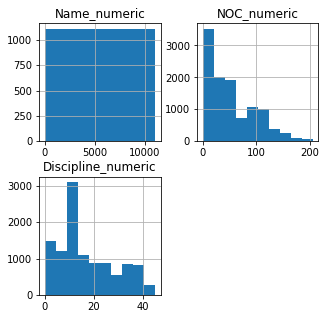

In [29]:
athletes_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6b84f0d0>,
      dtype=object)

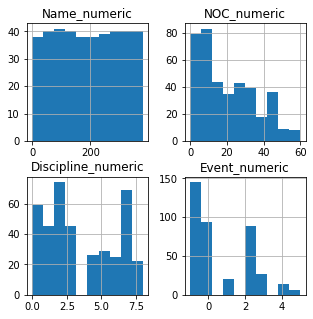

In [30]:
coaches_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6b8c2250>,
      dtype=object)

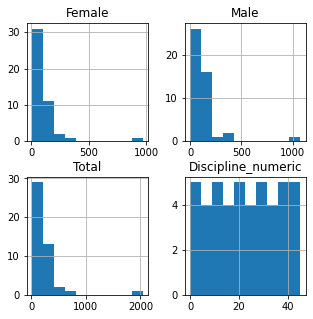

In [31]:
entries_gender_df.hist(figsize=(5,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6b326950>,
      dtype=object)

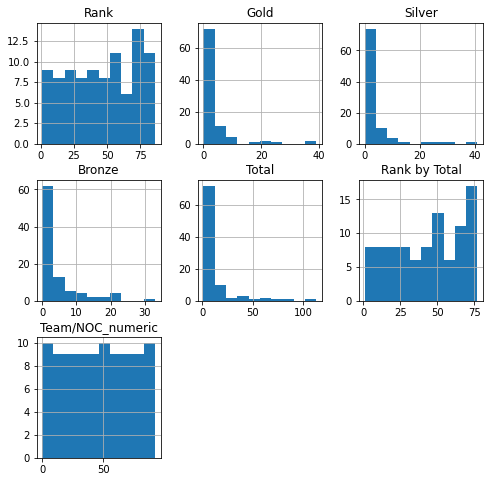

In [32]:
medals_df.hist(figsize=(8,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d6afc03d0>,
      dtype=object)

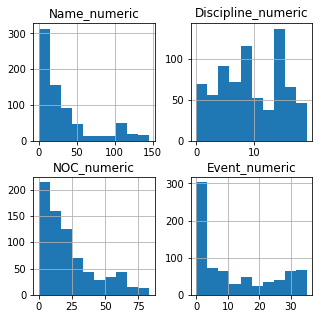

In [33]:
teams_df.hist(figsize=(5,5))

## 1.5 Show Outliers with Boxplot

In [34]:
def show_boxplot(dataframe):
  for column_name in dataframe.keys():
    if dataframe[column_name].dtype != np.object:
      dataframe.boxplot(column=column_name, figsize=(5,5))
      plt.show()

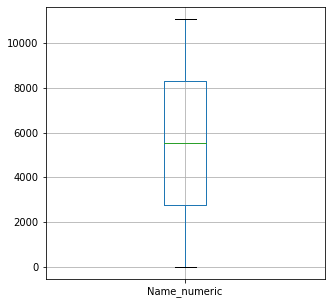

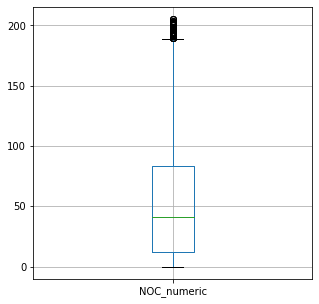

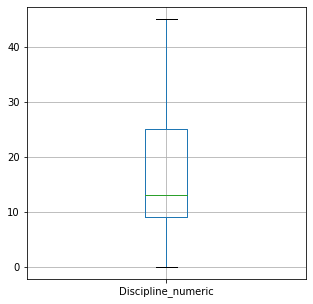

In [35]:
show_boxplot(athletes_df)

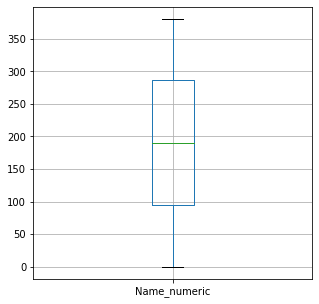

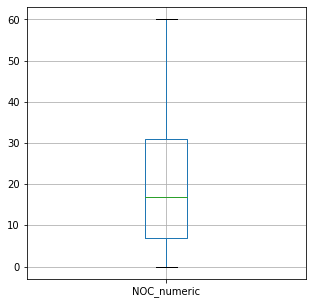

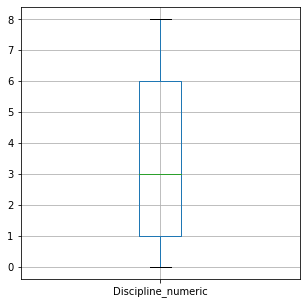

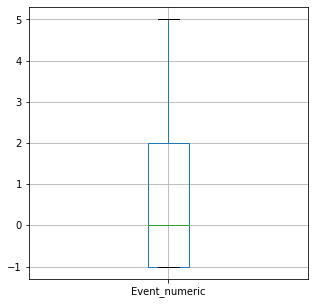

In [36]:
show_boxplot(coaches_df)

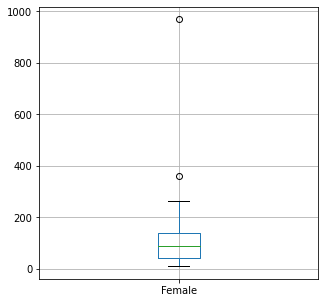

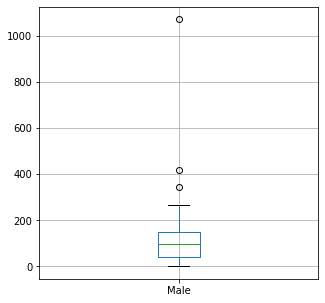

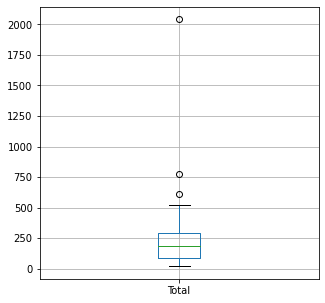

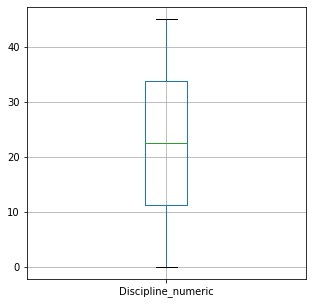

In [37]:
show_boxplot(entries_gender_df)

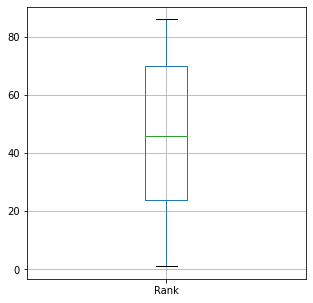

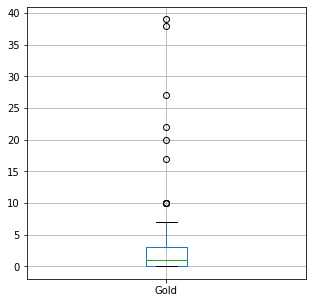

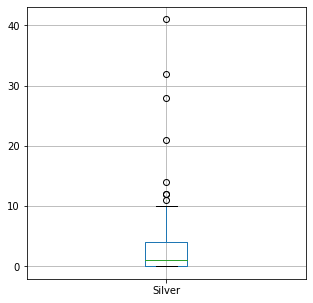

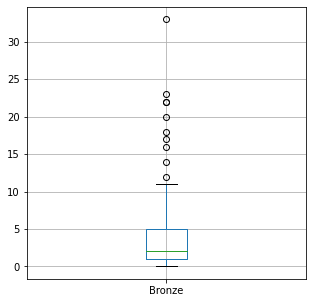

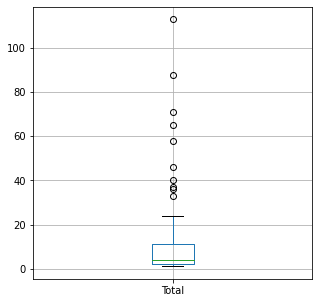

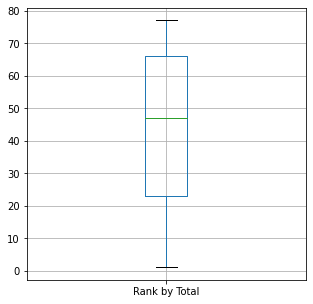

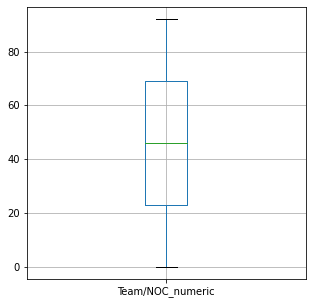

In [38]:
show_boxplot(medals_df)

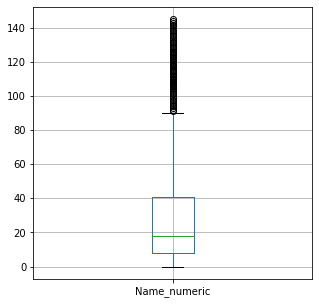

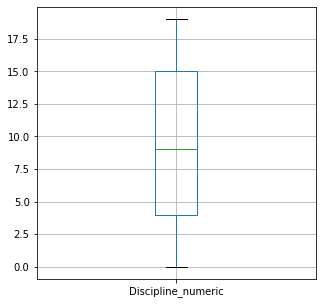

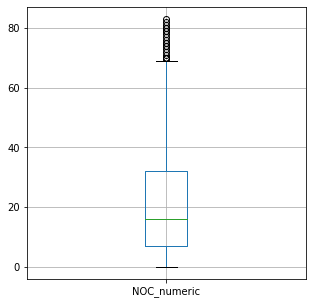

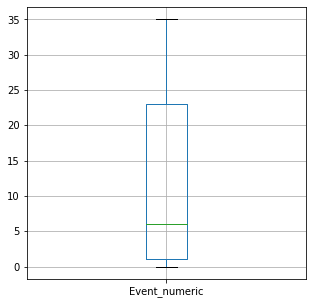

In [39]:
show_boxplot(teams_df)

## 1.6 dissimilarity matrix

for dissimilarity we used cosine similarity and then 1-cosine similarity shows dissimilarity of attributes

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
def dissimilarity_matrix(dataframe):
  for column_name in dataframe.keys():
    if dataframe[column_name].dtype == np.object:
      dataframe = dataframe.drop(column_name, axis=1, inplace=False)
  sim_matrix = cosine_similarity(dataframe.iloc[0:10])
  dissim_matrix = 1 - sim_matrix
  return dissim_matrix

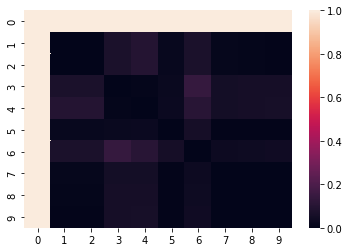

In [42]:
sns.heatmap(dissimilarity_matrix(athletes_df))

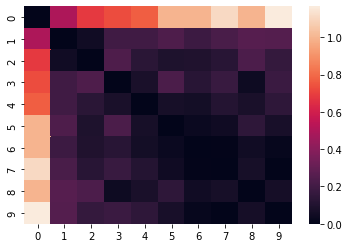

In [43]:
sns.heatmap(dissimilarity_matrix(coaches_df))

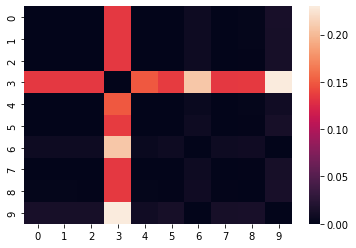

In [44]:
sns.heatmap(dissimilarity_matrix(entries_gender_df))

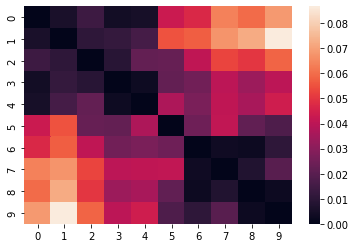

In [45]:
sns.heatmap(dissimilarity_matrix(medals_df))

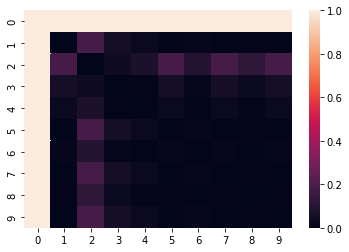

In [46]:
sns.heatmap(dissimilarity_matrix(teams_df))

## 1.8 find correlation of attributes and show scatter plot for them

In [47]:
import seaborn as sns
def show_scatter(dataframe, correlated_attrs):
  for x_column, y_column in correlated_attrs:
    sns.scatterplot(x=x_column, y=y_column, data=dataframe)
    plt.show()

In [48]:
def correlated_attributes(dataframe, threshold=0.95):
  correlated = []
  corr_matrix = dataframe.corr().abs()
  # print(corr_matrix)
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  for column in upper.columns:
    for index in upper.index:
      if(upper[column][index] > threshold):
        correlated.append([column, index])
  return correlated

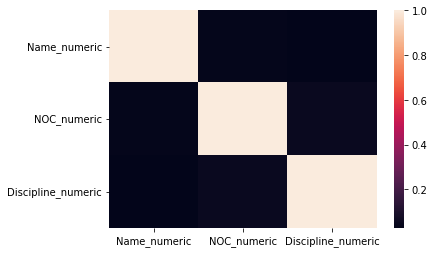

In [49]:
sns.heatmap(athletes_df.corr().abs())

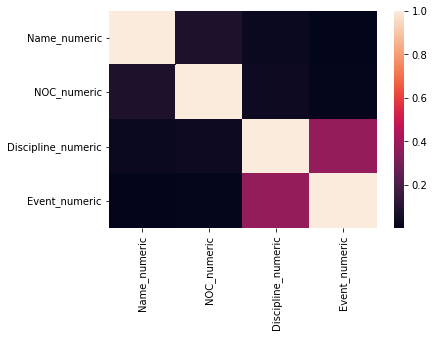

In [50]:
sns.heatmap(coaches_df.corr().abs())

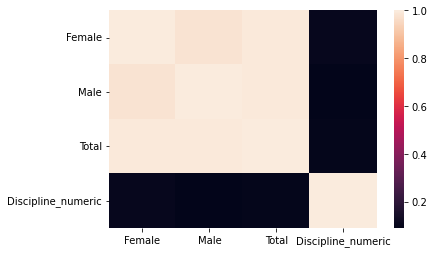

In [51]:
sns.heatmap(entries_gender_df.corr().abs())

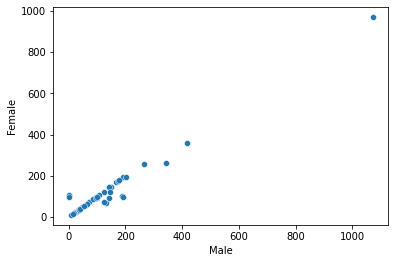

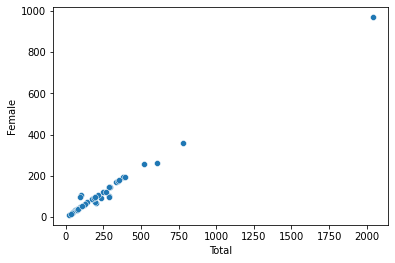

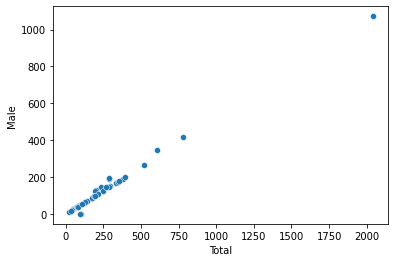

In [52]:
show_scatter(entries_gender_df, correlated_attributes(entries_gender_df))

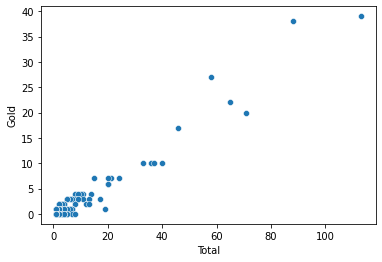

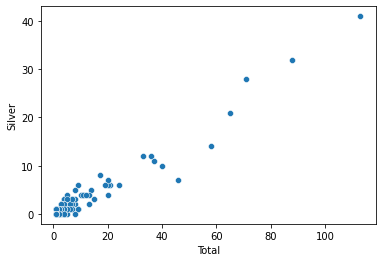

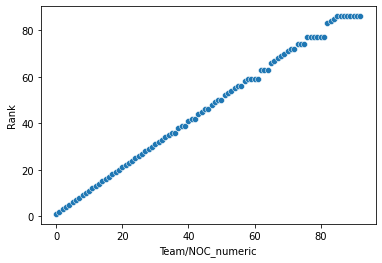

In [53]:
show_scatter(medals_df, correlated_attributes(medals_df))

# 2. Proprocessing Dataset

## 2.1 data cleaning

### 2.1.1 fill missing values with knn clustering

we know that we have missing values in coaches_df["Event"] 

and value of missing values in column Event is -1 in column "Event_numeric"

In [54]:
coaches_df['Event'].value_counts()

Men         94
Women       88
Duet        27
Softball    20
Team        14
Baseball     6
Name: Event, dtype: int64

In [55]:
coaches_df.loc[coaches_df['Event_numeric'] == -1, 'Event_numeric'] = np.nan
coaches_df.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,NaN,0,0,0,NaN
1,ABE Junya,Japan,Volleyball,NaN,1,1,1,NaN
2,ABE Katsuhiko,Japan,Basketball,NaN,2,1,2,NaN
3,ADAMA Cherif,Côte d'Ivoire,Football,NaN,3,2,0,NaN
4,AGEBA Yuya,Japan,Volleyball,NaN,4,1,1,NaN


In [56]:
coaches_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                394 non-null    object 
 1   NOC                 394 non-null    object 
 2   Discipline          394 non-null    object 
 3   Event               249 non-null    object 
 4   Name_numeric        394 non-null    int64  
 5   NOC_numeric         394 non-null    int64  
 6   Discipline_numeric  394 non-null    int64  
 7   Event_numeric       249 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 24.8+ KB


In [57]:
from sklearn.impute import KNNImputer
coaches_df_copy = coaches_df.copy()
coaches_df_copy.drop('NOC',axis=1,inplace=True)
coaches_df_copy.drop('Event',axis=1,inplace=True)
coaches_df_copy.drop('Name',axis=1,inplace=True)
coaches_df_copy.drop('Discipline',axis=1,inplace=True)

imputer = KNNImputer(n_neighbors=1, weights="uniform")
coaches_df_copy = imputer.fit_transform(coaches_df_copy)

In [58]:
coaches_df['Event'].value_counts(), coaches_df_copy.shape, coaches_df.shape

(Men         94
 Women       88
 Duet        27
 Softball    20
 Team        14
 Baseball     6
 Name: Event, dtype: int64, (394, 4), (394, 8))

In [59]:
coaches_df['Event_numeric'] = coaches_df_copy[:,-1]
coaches_df['Event_numeric'] = coaches_df['Event_numeric'].astype(np.int64)
coaches_df.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,NaN,0,0,0,0
1,ABE Junya,Japan,Volleyball,NaN,1,1,1,0
2,ABE Katsuhiko,Japan,Basketball,NaN,2,1,2,0
3,ADAMA Cherif,Côte d'Ivoire,Football,NaN,3,2,0,0
4,AGEBA Yuya,Japan,Volleyball,NaN,4,1,1,0


In [60]:
coaches_df['Event_numeric'].unique()

array([0, 1, 2, 3, 4, 5])

In [61]:
for i in coaches_df['Event_numeric'].unique():
  coaches_df.loc[(coaches_df['Event'].isnull()) & (coaches_df['Event_numeric'] == i), 'Event'] = (coaches_df[(coaches_df['Event_numeric']==i) & (coaches_df['Event'].isnull()==False)]['Event']).iloc[0]

In [62]:
coaches_df.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,Men,0,0,0,0
1,ABE Junya,Japan,Volleyball,Men,1,1,1,0
2,ABE Katsuhiko,Japan,Basketball,Men,2,1,2,0
3,ADAMA Cherif,Côte d'Ivoire,Football,Men,3,2,0,0
4,AGEBA Yuya,Japan,Volleyball,Men,4,1,1,0


### 2.1.2 remove outliers with IQR score

help link: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

for this section we consider that every data that is out of [q1 -1.5 * IQR, q3 + 1.5 * IQR] is outlier, so we removed them

In [63]:
def remove_outliers(dataframe):
  shape_of_df = dataframe.shape
  q1 = dataframe.quantile(0.25)
  q3 = dataframe.quantile(0.75)
  IQR = q3 - q1
  print(IQR)
  dataframe = dataframe[~((dataframe < (q1 - 1.5 * IQR)) |(dataframe > (q3 + 1.5 * IQR))).any(axis=1)]
  print("shape before removing outliers", shape_of_df)
  print("shape after removing outliers", dataframe.shape)
  return dataframe

In [64]:
athletes_df = remove_outliers(athletes_df)
coaches_df = remove_outliers(coaches_df)
medals_df = remove_outliers(medals_df)
entries_gender_df = remove_outliers(entries_gender_df)
teams_df = remove_outliers(teams_df)

Name_numeric          5529.0
NOC_numeric             71.0
Discipline_numeric      16.0
dtype: float64
shape before removing outliers (11085, 6)
shape after removing outliers (11030, 6)
Name_numeric          191.5
NOC_numeric            24.0
Discipline_numeric      5.0
Event_numeric           2.0
dtype: float64
shape before removing outliers (394, 8)
shape after removing outliers (394, 8)
Rank                46.0
Gold                 3.0
Silver               4.0
Bronze               4.0
Total                9.0
Rank by Total       43.0
Team/NOC_numeric    46.0
dtype: float64
shape before removing outliers (93, 8)
shape after removing outliers (82, 8)
Female                 96.00
Male                  109.50
Total                 203.25
Discipline_numeric     22.50
dtype: float64
shape before removing outliers (46, 5)
shape after removing outliers (43, 5)
Name_numeric          33.0
Discipline_numeric    11.0
NOC_numeric           25.0
Event_numeric         22.0
dtype: float64
shape befor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  import sys


In [65]:
coaches_df.head()
coaches_df.columns

Index(['Name', 'NOC', 'Discipline', 'Event', 'Name_numeric', 'NOC_numeric',
       'Discipline_numeric', 'Event_numeric'],
      dtype='object')

In [66]:
athletes_df.to_csv("athletes_dataframe.csv", index= False)
coaches_df.to_csv("coaches_dataframe.csv", index= False)
entries_gender_df.to_csv("entries_gender_dataframe.csv", index= False)
medals_df.to_csv("medals_dataframe.csv", index= False)
teams_df.to_csv("teams_dataframe.csv", index= False)

## 2.2 Redundancy

### 2.2.1 find redundancy in columns of datasets

In [67]:
def drop_redundant_columns(dataframe, to_drop):
  # Drop features 
  dataframe.drop(to_drop, axis=1, inplace=True)
  print("columns that are redundant and removed from dataset are:")
  print(to_drop)
  return dataframe

In [68]:
correlated_attributes(athletes_df)

[]

In [69]:
athletes_df = drop_redundant_columns(athletes_df,['Name', 'NOC', 'Discipline'])

columns that are redundant and removed from dataset are:
['Name', 'NOC', 'Discipline']


In [70]:
correlated_attributes(coaches_df)

[]

In [71]:
coaches_df = drop_redundant_columns(coaches_df,['Name', 'NOC', 'Discipline', 'Event'])

columns that are redundant and removed from dataset are:
['Name', 'NOC', 'Discipline', 'Event']


In [72]:
correlated_attributes(entries_gender_df)

[['Total', 'Female'], ['Total', 'Male']]

In [73]:
entries_gender_df = drop_redundant_columns(entries_gender_df,['Total','Discipline'])

columns that are redundant and removed from dataset are:
['Total', 'Discipline']


In [74]:
correlated_attributes(medals_df)

[['Team/NOC_numeric', 'Rank']]

In [75]:
medals_df = drop_redundant_columns(medals_df, ['Rank','Team/NOC'])

columns that are redundant and removed from dataset are:
['Rank', 'Team/NOC']


In [76]:
correlated_attributes(teams_df)

[]

In [77]:
teams_df = drop_redundant_columns(teams_df, ['Name','Discipline','NOC','Event'])

columns that are redundant and removed from dataset are:
['Name', 'Discipline', 'NOC', 'Event']


### 2.2.2 find redundancy in rows of datasets

In [78]:
def find_redundancy_in_rows(dataframe):
  return dataframe[dataframe.duplicated(keep=False)]

In [79]:
find_redundancy_in_rows(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric
253,253,22,4
254,253,22,4


In [80]:
find_redundancy_in_rows(coaches_df)

,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
143,137,30,4,1
144,137,30,4,1


In [81]:
find_redundancy_in_rows(entries_gender_df)

,Female,Male,Discipline_numeric


In [82]:
find_redundancy_in_rows(medals_df)

,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric


In [83]:
find_redundancy_in_rows(teams_df)

,Name_numeric,Discipline_numeric,NOC_numeric,Event_numeric


In [84]:
athletes_df.drop_duplicates(keep='first', inplace=True)
coaches_df.drop_duplicates(keep='first', inplace=True)

In [85]:
find_redundancy_in_rows(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric


In [86]:
find_redundancy_in_rows(coaches_df)

,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric


## 2.3 Numerosity Reduction

In [87]:
athletes_df.shape, coaches_df.shape, entries_gender_df.shape, medals_df.shape, teams_df.shape

((11029, 3), (393, 4), (43, 3), (82, 6), (644, 4))

In [88]:
athletes_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,0,0,0
1,1,1,1
2,2,2,2
3,3,1,3
4,4,1,3


choose best number of clusters for kmeans algorithm

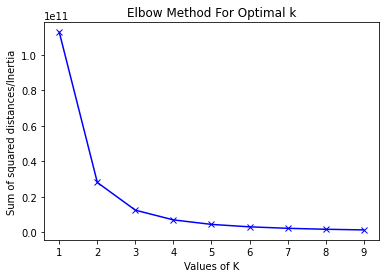

In [89]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(athletes_df)
  Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

clustering data and random select up to 2000 random data from each cluster

In [90]:
km = KMeans(n_clusters=3).fit(athletes_df)
cluster_map = pd.DataFrame()
cluster_map['data_index'] = athletes_df.index.values
cluster_map['cluster'] = km.labels_

In [91]:
cluster_map['cluster'].value_counts()

1    3699
2    3665
0    3665
Name: cluster, dtype: int64

In [92]:
SAMPLES_FROM_EACH_CLUSTER = 2000
samples_index = []
for cluster_label in cluster_map['cluster'].unique():
  x = cluster_map.loc[cluster_map['cluster'] == cluster_label].sample(n = SAMPLES_FROM_EACH_CLUSTER)
  samples_index.extend(x['data_index'].to_numpy().tolist())

In [93]:
athletes_df = athletes_df.loc[samples_index]
athletes_df.reset_index(drop=True, inplace=True)

In [94]:
athletes_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,439,113,18
1,2105,85,10
2,82,4,7
3,3304,188,5
4,251,22,4


## 2.4 Normalization

In [95]:
import pandas as pd
from sklearn import preprocessing
def normalize_with_MinMaxScaler(dataframe):
  x = dataframe.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  dataframe = pd.DataFrame(x_scaled, columns=dataframe.keys())
  return dataframe

In [96]:
from scipy import stats
def normalize_with_zscore(dataframe):
  x_scaled = stats.zscore(dataframe)
  return pd.DataFrame(x_scaled, columns=dataframe.keys())

In [97]:
def normalize_with_Normalizer(dataframe):
  normalizer = preprocessing.Normalizer()
  x_scaled = normalizer.fit_transform(dataframe)
  dataframe = pd.DataFrame(x_scaled, columns=dataframe.keys())
  return dataframe

In [98]:
athletes_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,439,113,18
1,2105,85,10
2,82,4,7
3,3304,188,5
4,251,22,4


In [99]:
normalize_with_MinMaxScaler(athletes_df).head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,0.039533,0.597884,0.400000
1,0.190248,0.449735,0.222222
2,0.007237,0.021164,0.155556
3,0.298715,0.994709,0.111111
4,0.022526,0.116402,0.088889


In [100]:
normalize_with_zscore(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric
0,-1.599178,1.447860,0.122964
1,-1.076876,0.800875,-0.562869
2,-1.711099,-1.070760,-0.820057
3,-0.700983,3.180855,-0.991516
4,-1.658117,-0.654841,-1.077245
...,...,...,...
5995,0.607906,-1.116973,-0.562869
5996,1.402330,0.754662,-0.134223
5997,1.132088,1.933099,1.494632
5998,1.390730,-0.169602,-0.562869


In [101]:
normalize_with_Normalizer(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric
0,0.967670,0.249081,0.039677
1,0.999174,0.040347,0.004747
2,0.995201,0.048546,0.084956
3,0.998384,0.056809,0.001511
4,0.996055,0.087304,0.015873
...,...,...,...
5995,0.999999,0.000267,0.001337
5996,0.999965,0.008289,0.001498
5997,0.999886,0.014642,0.003715
5998,0.999990,0.004310,0.001002


In [102]:
normalize_with_Normalizer(athletes_df)

,Name_numeric,NOC_numeric,Discipline_numeric
0,0.967670,0.249081,0.039677
1,0.999174,0.040347,0.004747
2,0.995201,0.048546,0.084956
3,0.998384,0.056809,0.001511
4,0.996055,0.087304,0.015873
...,...,...,...
5995,0.999999,0.000267,0.001337
5996,0.999965,0.008289,0.001498
5997,0.999886,0.014642,0.003715
5998,0.999990,0.004310,0.001002


In [103]:
athletes_norm_df = normalize_with_zscore(athletes_df)
athletes_norm_df.reset_index(drop=True, inplace=True)
coaches_norm_df = normalize_with_zscore(coaches_df)
coaches_norm_df.reset_index(drop=True, inplace=True)
entries_gender_norm_df = normalize_with_zscore(entries_gender_df)
entries_gender_norm_df.reset_index(drop=True, inplace=True)
medals_norm_df = normalize_with_zscore(medals_df)
medals_norm_df.reset_index(drop=True, inplace=True)
teams_norm_df = normalize_with_zscore(teams_df)
teams_norm_df.reset_index(drop=True, inplace=True)

In [104]:
athletes_norm_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric
0,-1.599178,1.447860,0.122964
1,-1.076876,0.800875,-0.562869
2,-1.711099,-1.070760,-0.820057
3,-0.700983,3.180855,-0.991516
4,-1.658117,-0.654841,-1.077245


In [105]:
coaches_norm_df.head()

,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,-1.727074,-1.270804,-1.341586,-1.065579
1,-1.718002,-1.206212,-0.960078,-1.065579
2,-1.708929,-1.206212,-0.578571,-1.065579
3,-1.699856,-1.141620,-1.341586,-1.065579
4,-1.690783,-1.206212,-0.960078,-1.065579


In [106]:
entries_gender_norm_df.head()

,Female,Male,Discipline_numeric
0,-1.023526,-0.954657,-1.708309
1,-0.451482,-0.463405,-1.632968
2,0.156314,0.058550,-1.557627
3,0.281449,-1.445910,-1.482286
4,-0.058202,-0.110318,-1.331605


In [107]:
medals_norm_df.head()

,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric
0,2.857927,2.237029,3.458641,3.396121,-1.776803,-1.706174
1,2.857927,2.237029,2.256910,2.836921,-1.729376,-1.664659
2,2.857927,2.237029,1.856333,2.650520,-1.681948,-1.623144
3,2.857927,0.655681,1.055179,1.718519,-1.444810,-1.581629
4,2.322881,2.764145,1.856333,2.650520,-1.681948,-1.540114


In [108]:
teams_norm_df.head()

,Name_numeric,Discipline_numeric,NOC_numeric,Event_numeric
0,-1.086621,-1.608614,-1.219974,-0.980437
1,-1.033684,-1.608614,-1.151165,-0.980437
2,-1.033684,-1.608614,-1.151165,-0.893503
3,-0.980746,-1.608614,-1.082356,-0.893503
4,-0.927808,-1.608614,-1.013546,-0.893503


## 2.5 Dimentionality Reduction

In [109]:
athletes_df.shape, coaches_df.shape, entries_gender_df.shape, medals_df.shape, teams_df.shape

((6000, 3), (393, 4), (43, 3), (82, 6), (644, 4))

In [110]:
def dim_reduction_PCA(dataframe, n_components=2):
  pca = PCA(n_components = n_components)
  x = pca.fit_transform(dataframe)
  x = pd.DataFrame(x)
  return x

In [111]:
athletes_pca_df = dim_reduction_PCA(athletes_df)
coaches_pca_df = dim_reduction_PCA(coaches_df)
entries_gender_pca_df = dim_reduction_PCA(entries_gender_df)
medals_pca_df = dim_reduction_PCA(medals_df)
teams_pca_df = dim_reduction_PCA(teams_df)

In [112]:
athletes_pca_df.shape, coaches_pca_df.shape, entries_gender_pca_df.shape, medals_pca_df.shape, teams_pca_df.shape

((6000, 2), (393, 2), (43, 2), (82, 2), (644, 2))

In [113]:
medals_df.head()

,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric
10,7,6,11,24,11,10
11,7,6,8,21,12,11
12,7,6,7,20,13,12
13,7,3,5,15,18,13
14,6,7,7,20,13,14


In [114]:
coaches_df['Event_numeric'].value_counts()

0    149
2    141
1     40
3     39
4     16
5      8
Name: Event_numeric, dtype: int64

# 3. models

## 3.1 unsupervised 

first we prepared data for unsupervised models. here we used athletes dataframe for unsupervised models

In [115]:
athletes_for_model = pd.read_csv("athletes_dataframe.csv")

In [116]:
athletes_for_model.head()

,Name,NOC,Discipline,Name_numeric,NOC_numeric,Discipline_numeric
0,AALERUD Katrine,Norway,Cycling Road,0,0,0
1,ABAD Nestor,Spain,Artistic Gymnastics,1,1,1
2,ABAGNALE Giovanni,Italy,Rowing,2,2,2
3,ABALDE Alberto,Spain,Basketball,3,1,3
4,ABALDE Tamara,Spain,Basketball,4,1,3


In [117]:
athletes_for_model.drop(columns=['Name','NOC','Discipline','Name_numeric'], inplace=True)

In [118]:
athletes_for_model = normalize_with_zscore(athletes_for_model)

In [119]:
athletes_for_model.head()

,NOC_numeric,Discipline_numeric
0,-1.161057,-1.426067
1,-1.137914,-1.340287
2,-1.114771,-1.254507
3,-1.137914,-1.168726
4,-1.137914,-1.168726


### 3.1.1 Kmeans model

In [120]:
kmeans_train = athletes_for_model[0:9000]
kmeans_test = athletes_for_model[9000:]

In [121]:
kmeans_train.shape, kmeans_test.shape

((9000, 2), (2030, 2))

In [122]:
# kmeans_Xtrain, kmeans_Xtest, keams_Ytrain, kmeans_Ytest = train_test_split(athletes_for_model, y_data_encoded, test_size=0.2, random_state=40)

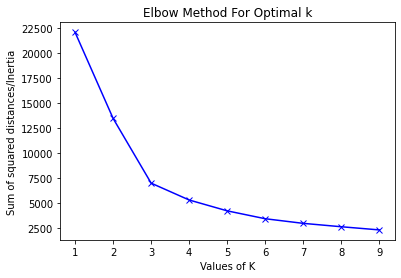

In [123]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(athletes_for_model)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [124]:
kmeans_model = KMeans(n_clusters=3, random_state=0)
label = kmeans_model.fit_predict(athletes_for_model)

now after clusterin we put label of rows in new column named 'label'

In [125]:
athletes_for_model['label'] = label

In [126]:
athletes_for_model.head()

,NOC_numeric,Discipline_numeric,label
0,-1.161057,-1.426067,1
1,-1.137914,-1.340287,1
2,-1.114771,-1.254507,1
3,-1.137914,-1.168726,1
4,-1.137914,-1.168726,1


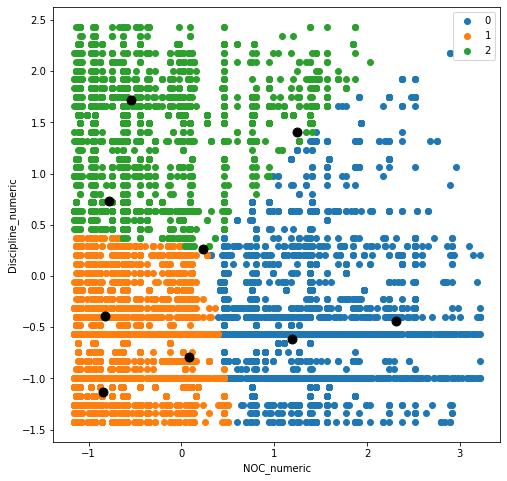

In [127]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
fig = plt.figure(figsize=(8,8))
#plotting the results:
for i in u_labels:
    plt.scatter(athletes_for_model[athletes_for_model['label'] == i]['NOC_numeric'] , 
                athletes_for_model[athletes_for_model['label'] == i]['Discipline_numeric'] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.xlabel("NOC_numeric")
plt.ylabel("Discipline_numeric")
plt.legend()
plt.show()

### 3.1.2 DBScan model

In [128]:
dbscan_data = pd.read_csv("athletes_dataframe.csv")
dbscan_data.drop(columns=['Name','NOC','Discipline','Name_numeric'], inplace=True)

In [129]:
from sklearn.cluster import DBSCAN
def create_dbscan_model(eps, minsamples):
  return DBSCAN(eps=eps, min_samples=minsamples).fit(dbscan_data)

In [130]:
import seaborn as sns
def show_clusters_for_dbscan(dbscan_model):
  print('number of clusters in DBScan is ', len(set(dbscan_model.labels_)))
  fig = plt.figure(figsize=(7,7))
  sns.scatterplot(x=athletes_for_model['NOC_numeric'], y=athletes_for_model['Discipline_numeric'], 
                  hue=dbscan_model.labels_)
  plt.show()

##### for eps=2 and min_samples=20

number of clusters in DBScan is  31


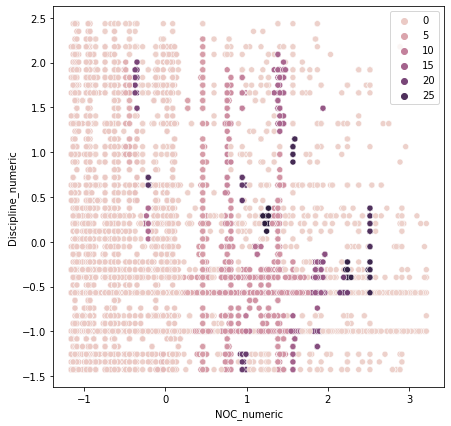

In [131]:
dbscan_model = create_dbscan_model(2,20)
show_clusters_for_dbscan(dbscan_model)

##### for eps=1 and min_samples=20

number of clusters in DBScan is  96


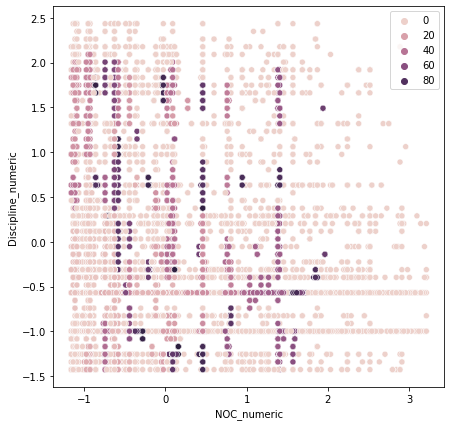

In [132]:
dbscan_model = create_dbscan_model(1,20)
show_clusters_for_dbscan(dbscan_model)

##### for eps=1 and min_samples=30

number of clusters in DBScan is  72


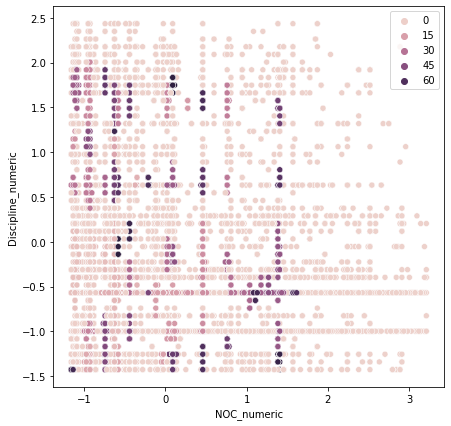

In [133]:
dbscan_model = create_dbscan_model(1,30)
show_clusters_for_dbscan(dbscan_model)

## supervised

In [134]:
def plot_confusionmatrix(y_pred,y_true,dom, classes = ["0","1","2"]):
    cf = confusion_matrix(y_pred,y_true)
    print(f'Accuracy Score on {dom} set : '+str(accuracy_score(y_true, y_pred)))
    print(f'{dom} Confusion matrix')
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

here we use data that labeled with Kmeans model for train and evaluate supervised models

In [135]:
athletes_for_model.head()

,NOC_numeric,Discipline_numeric,label
0,-1.161057,-1.426067,1
1,-1.137914,-1.340287,1
2,-1.114771,-1.254507,1
3,-1.137914,-1.168726,1
4,-1.137914,-1.168726,1


In [136]:
from sklearn.model_selection import train_test_split
x_data, y_data = (athletes_for_model[['NOC_numeric','Discipline_numeric']],athletes_for_model['label'])
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

### 3.2.1 MLP model

In [137]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [138]:
from tensorflow.keras.utils import to_categorical
y_data_encoded = to_categorical(athletes_for_model['label'])
x_train_val, x_test2, y_train_val, y_test2 = train_test_split(athletes_for_model[['NOC_numeric','Discipline_numeric']],y_data_encoded , test_size=0.2, random_state=40)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=40)

In [139]:
x_train2.shape, x_test2.shape, x_val2.shape

((7059, 2), (2206, 2), (1765, 2))

In [140]:
y_train2.shape, y_test2.shape, y_val2.shape

((7059, 3), (2206, 3), (1765, 3))

In [141]:
model = tf.keras.Sequential(layers=[Input(shape=(2,)),
                                    Dense(128, activation='relu', name="dense_128"),
                                    Dropout(0.25, name="dropout_1"),
                                    Dense(64, activation='relu', name="dense_64"),
                                    Dropout(0.3, name="dropout_2"),
                                    Dense(32, activation='relu', name="dense_32"),
                                    Dropout(0.15,name="dropout_3"),
                                    Dense(16, activation='relu', name="dense_16"),
                                    Dropout(0.1,name="dropout_4"),
                                    Dense(3, activation='softmax', name="dense_out")
                                    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_128 (Dense)           (None, 128)               384       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 16)                5

In [142]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=25)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [143]:
history = model.fit(x_train2, y_train2, epochs=2000, batch_size=16,validation_data=(x_val2, y_val2), callbacks=[early_stop])

Epoch 1/2000
442/442 [==============================] - 4s 7ms/step - loss: 0.2959 - accuracy: 0.8960 - val_loss: 0.0330 - val_accuracy: 0.9943
Epoch 2/2000
442/442 [==============================] - 2s 5ms/step - loss: 0.0651 - accuracy: 0.9775 - val_loss: 0.0283 - val_accuracy: 0.9904
Epoch 3/2000
442/442 [==============================] - 2s 4ms/step - loss: 0.0450 - accuracy: 0.9853 - val_loss: 0.0256 - val_accuracy: 0.9892
Epoch 4/2000
442/442 [==============================] - 1s 3ms/step - loss: 0.0467 - accuracy: 0.9831 - val_loss: 0.0184 - val_accuracy: 0.9949
Epoch 5/2000
442/442 [==============================] - 1s 3ms/step - loss: 0.0385 - accuracy: 0.9856 - val_loss: 0.0173 - val_accuracy: 0.9949
Epoch 6/2000
442/442 [==============================] - 1s 3ms/step - loss: 0.0361 - accuracy: 0.9874 - val_loss: 0.0124 - val_accuracy: 0.9972
Epoch 7/2000
442/442 [==============================] - 1s 3ms/step - loss: 0.0346 - accuracy: 0.9888 - val_loss: 0.0159 - val_accuracy:

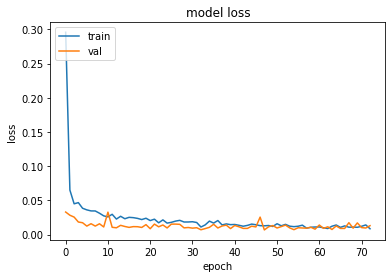

In [144]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [145]:
model.evaluate(x_test2,y_test2)

69/69 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9982


[0.006379005499184132, 0.9981867671012878]

Accuracy Score on Train set : 0.998158379373849
Train Confusion matrix


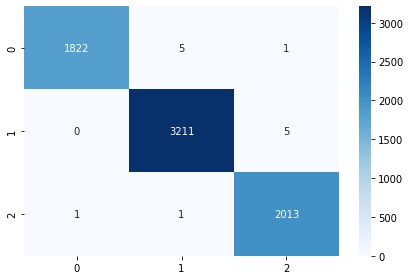

Accuracy Score on Test set : 0.9981867633726201
Test Confusion matrix


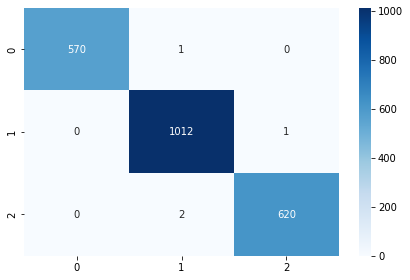

In [146]:
y_train_pred = np.argmax(model.predict(x_train2), axis=1)
y_test_pred = np.argmax(model.predict(x_test2), axis=1)
y_train2 = np.argmax(y_train2, axis=1)
y_test2 = np.argmax(y_test2, axis=1)
plot_confusionmatrix(y_train_pred,y_train2,dom='Train')
plot_confusionmatrix(y_test_pred,y_test2,dom='Test')

In [147]:
y_train_pred

array([0, 2, 0, ..., 1, 1, 0])

In [148]:
model.save('my_model.h5')

### 3.2.2 svm model

In [149]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

##### svm model with linear kernel

Accuracy Score on Train set : 0.994301256313949
Train Confusion matrix


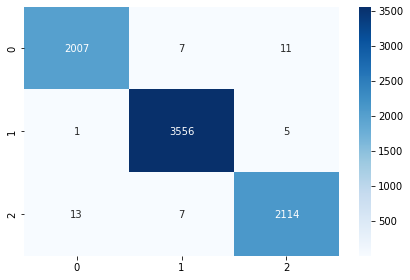

Accuracy Score on Test set : 0.9945602901178604
Test Confusion matrix


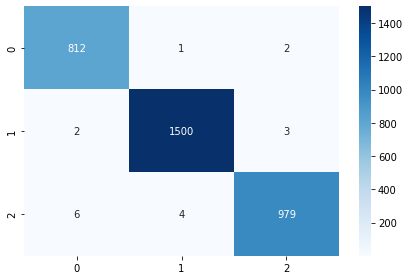

In [150]:
svm_clf = SVC(kernel='linear')
svm_clf = svm_clf.fit(X_train, y_train)

y_test_pred = svm_clf.predict(X_test)
y_train_pred = svm_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

##### svm model with rbf kernel

Accuracy Score on Train set : 0.995596425333506
Train Confusion matrix


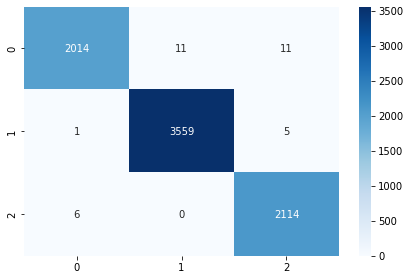

Accuracy Score on Test set : 0.9963735267452403
Test Confusion matrix


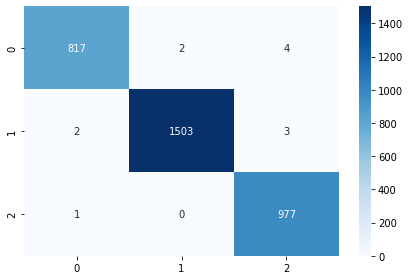

In [151]:
svm_clf = SVC(kernel='rbf')
svm_clf = svm_clf.fit(X_train, y_train)

y_test_pred = svm_clf.predict(X_test)
y_train_pred = svm_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

##### svm model with rbf kernel and gamma = auto

Accuracy Score on Train set : 0.995596425333506
Train Confusion matrix


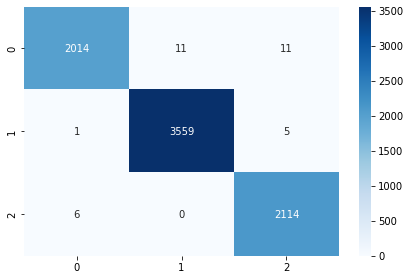

Accuracy Score on Test set : 0.9963735267452403
Test Confusion matrix


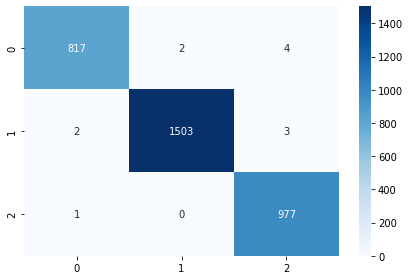

In [152]:
svm_clf = SVC(kernel='rbf', gamma = 'auto')
svm_clf = svm_clf.fit(X_train, y_train)

y_test_pred = svm_clf.predict(X_test)
y_train_pred = svm_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [153]:
svm_scores = cross_val_score(svm_clf, x_data, y_data, cv=10)
k_fold_svm_evaluate = sum(svm_scores)/len(svm_scores)
print("k-fold evaluate for svm model: ",k_fold_svm_evaluate)

k-fold evaluate for svm model:  0.9952855847688123


### 3.2.3 KNN model

In [154]:
from sklearn.neighbors import KNeighborsClassifier

### find optimal value for n_neighbors parameter

find n_neghbors in minimum error rate

Minimum error:- 0.0006044122091266244 at K = 1


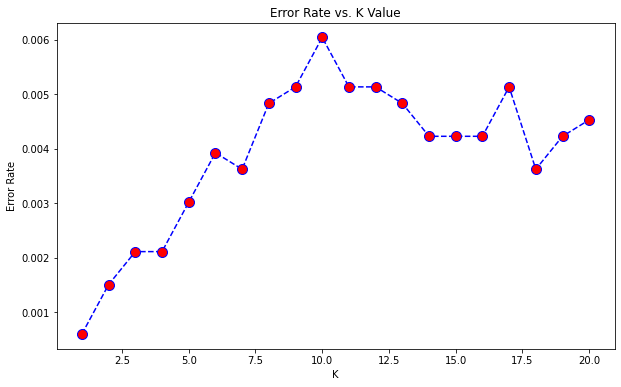

In [155]:
error_rate = []
for i in range(1,21):
  knn_clf = KNeighborsClassifier(n_neighbors=i, p=2).fit(X_train, y_train)
  pred_i = knn_clf.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,21),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",1+error_rate.index(min(error_rate)))

find n_neighbors in maximum accuracy rate

Max accuracy:- 0.9996373526745239 at K = 1


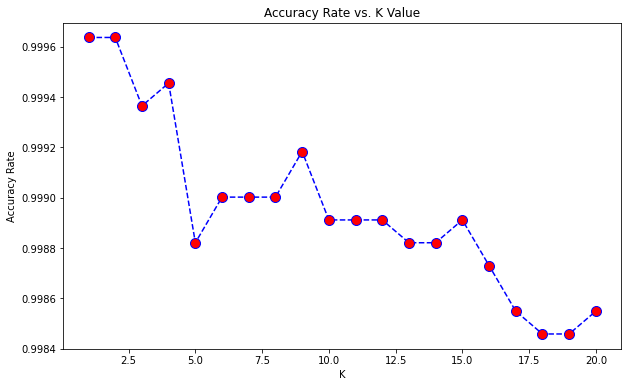

In [156]:
accuracy_rate = []
for i in range(1,21):
  knn_clf = KNeighborsClassifier(n_neighbors=i, weights='distance', p=2)
  # pred_i = knn_clf.predict(X_norm_test)
  k_fold_knn_evaluate = cross_val_score(knn_clf, x_data, y_data, cv=10)
  accuracy_rate.append(k_fold_knn_evaluate.mean())

plt.figure(figsize=(10,6))
plt.plot(range(1,21),accuracy_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')
print("Max accuracy:-",max(accuracy_rate),"at K =",1+accuracy_rate.index(max(accuracy_rate)))

Accuracy Score on Train set : 1.0
Train Confusion matrix


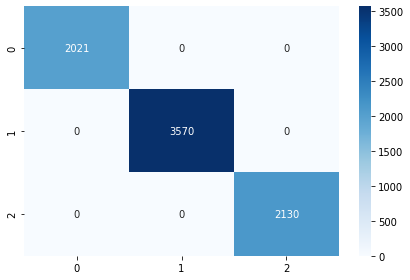

Accuracy Score on Test set : 0.9993955877908733
Test Confusion matrix


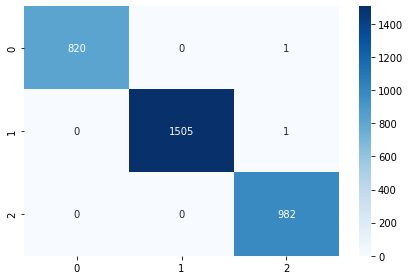

In [157]:
knn_clf = KNeighborsClassifier(n_neighbors=2,weights='distance', p=2).fit(X_train, y_train)
y_test_pred = knn_clf.predict(X_test)
y_train_pred = knn_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [158]:
k_fold_knn_evaluate = cross_val_score(knn_clf, x_data, y_data, cv=10)
print("k-fold evaluate for knn model: %0.2f" % (k_fold_knn_evaluate.mean()))

k-fold evaluate for knn model: 1.00


### 3.2.4 Bayes model

In [159]:
X_train.head(), X_test.head(), y_train.head(), y_test.head()

(      NOC_numeric  Discipline_numeric
 758     -0.582485            0.375318
 7920    -0.281628            2.176703
 8803    -0.443628            1.147340
 9037     1.268945           -0.568265
 3931    -0.744485            1.833582,       NOC_numeric  Discipline_numeric
 2590    -0.582485            1.147340
 220     -0.767628           -0.139364
 223     -0.767628           -0.139364
 5977     1.477231            0.203757
 9538    -0.952771            0.718439, 758     2
 7920    2
 8803    2
 9037    0
 3931    2
 Name: label, dtype: int32, 2590    2
 220     1
 223     1
 5977    0
 9538    2
 Name: label, dtype: int32)

In [160]:
correlated_attributes(athletes_for_model)

[]

because there is no correlated attributes so we can use Naive Bayes

In [161]:
from sklearn.naive_bayes import GaussianNB

In [162]:
bayes_clf = GaussianNB()

In [163]:
bayes_clf.fit(X_train,y_train)

GaussianNB()

Accuracy Score on Train set : 0.9821266675301127
Train Confusion matrix


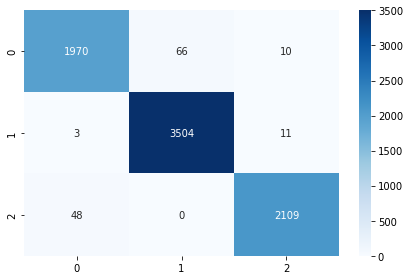

Accuracy Score on Test set : 0.9827742520398912
Test Confusion matrix


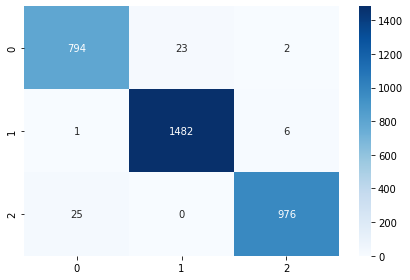

In [164]:
y_test_pred = bayes_clf.predict(X_test)
y_train_pred = bayes_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [165]:
k_fold_bayes_evaluate = cross_val_score(bayes_clf, x_data, y_data, cv=10)
print("k-fold evaluate for bayes model: %0.2f" % (k_fold_bayes_evaluate.mean()))

k-fold evaluate for bayes model: 0.98


### 3.2.5 decision tree

#### 3.2.5.1 decision tree without pruning

In [166]:
from sklearn import tree

In [167]:
dt_clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best")
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [168]:
k_fold_dt_evaluate = cross_val_score(dt_clf, x_data, y_data, cv=10)
print("k-fold evaluate for decision tree model: %0.2f" % (k_fold_dt_evaluate.mean()))

k-fold evaluate for decision tree model: 1.00


Accuracy Score on Train set : 1.0
Train Confusion matrix


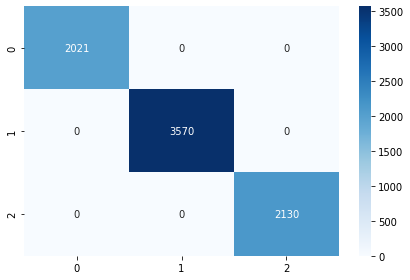

Accuracy Score on Test set : 0.9981867633726201
Test Confusion matrix


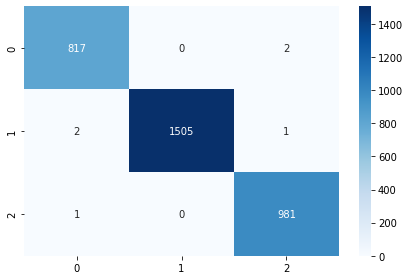

In [169]:
y_test_pred = dt_clf.predict(X_test)
y_train_pred = dt_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

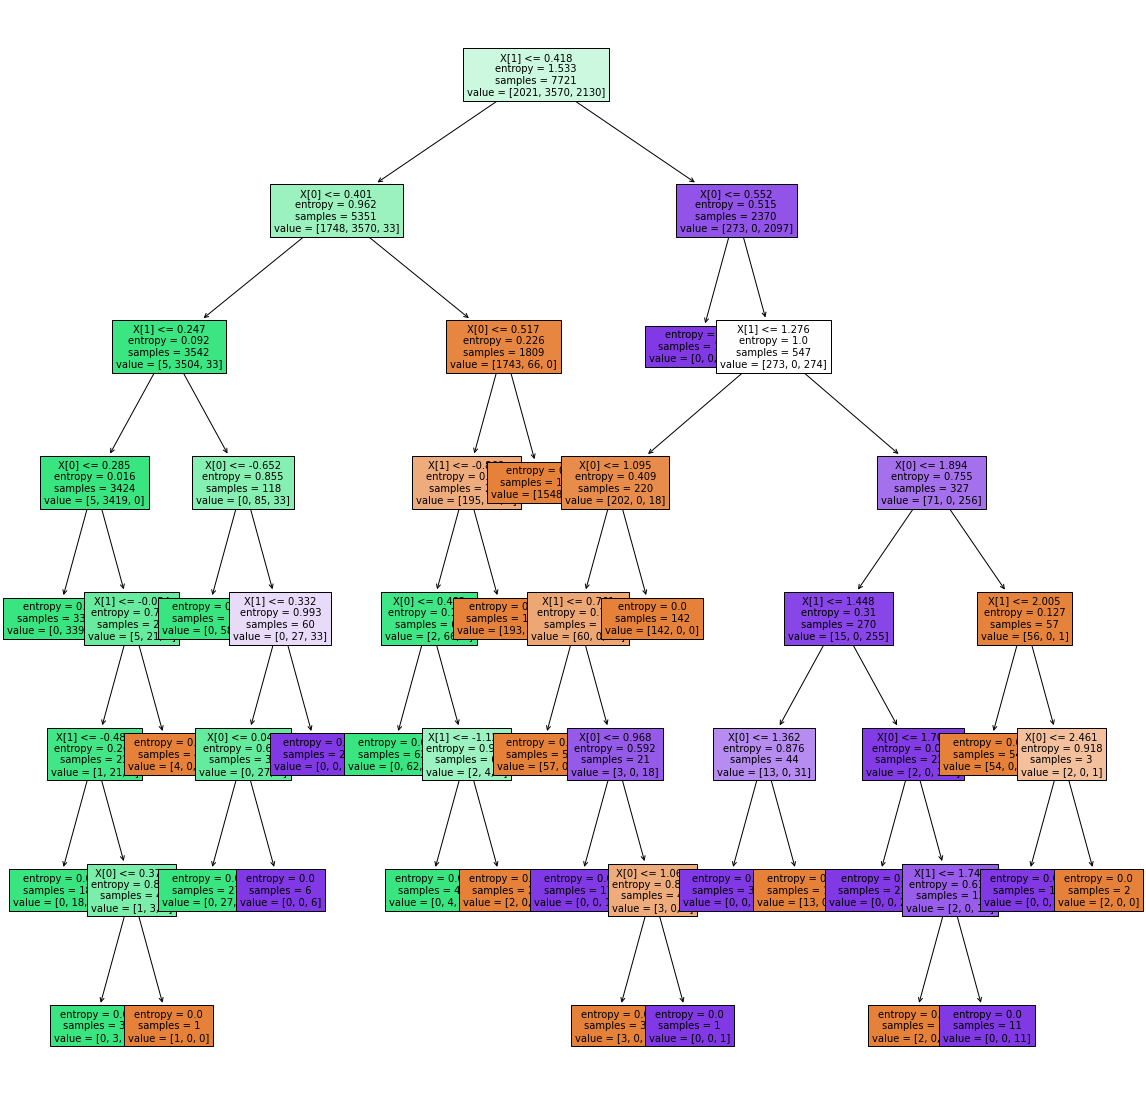

In [170]:
plt.figure(figsize=(20,20))
tree.plot_tree(dt_clf, fontsize=10, filled=True)
plt.show()

#### 3.2.5.2 decision tree with pruning using ccp_alpha parameter

In [171]:
path = dt_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.00000000e+00 3.56804495e-04 3.80056322e-04 4.20296917e-04
 5.83858007e-04 7.13608989e-04 9.72372273e-04 1.04286602e-03
 1.09583920e-03 1.18896721e-03 1.61822259e-03 2.92361979e-03
 4.34294670e-03 4.65519673e-03 4.79124451e-03 5.01597196e-03
 5.35192036e-03 2.02055932e-02 2.19260883e-02 2.56246838e-02
 2.72335122e-02 8.73512020e-02 5.71814532e-01 7.08295695e-01]


In [172]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

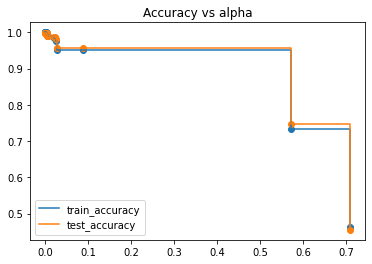

In [173]:
# here we want to find best value for ccp_alpha so we calculate accuracy of decision tree in each value of ccp_alpha
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

Accuracy Score on Train set : 0.9511721279626991
Train Confusion matrix


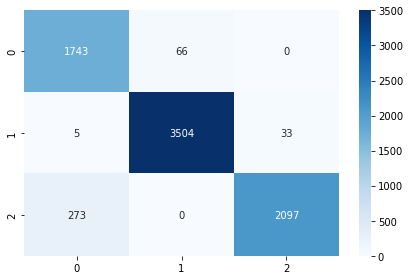

Accuracy Score on Test set : 0.957388939256573
Test Confusion matrix


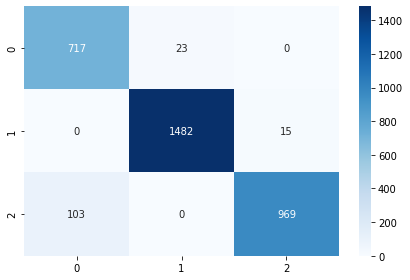

In [174]:
# now after our analyse we decide that use ccp_alpha=0.5 for out pruned model
dt_clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0,ccp_alpha=0.5)
dt_clf.fit(X_train,y_train)
y_test_pred = dt_clf.predict(X_test)
y_train_pred = dt_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

In [175]:
k_fold_dt_evaluate = cross_val_score(dt_clf, x_data, y_data, cv=10)
print("k-fold evaluate for decision tree model: %0.2f" % (k_fold_dt_evaluate.mean()))

k-fold evaluate for decision tree model: 0.95


### 3.2.6 Ensemble

#### 3.2.6.1 VotingClassifier

In [176]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

svm_clf = SVC(kernel='rbf', gamma = 'auto')
knn_clf = KNeighborsClassifier(n_neighbors=2,weights='distance', p=2)
dt_clf = tree.DecisionTreeClassifier(criterion="entropy", splitter="random")
rfc_clf = RandomForestClassifier(n_estimators=50, random_state=1, criterion="entropy")

ensemble_clf = VotingClassifier(estimators=[('svm', svm_clf), ('knn', knn_clf), ('dt', dt_clf), ('rfc', rfc_clf)],voting='hard')

for clf, label in zip([svm_clf, knn_clf, dt_clf, rfc_clf, ensemble_clf], ['SVM','KNN','Decision Tree', 'Random Forest', 'Ensemble']):
    scores = cross_val_score(clf, x_data, y_data, scoring='accuracy', cv=10)
    print("Accuracy of %s: %0.2f" % (label, scores.mean()))

Accuracy of SVM: 1.00
Accuracy of KNN: 1.00
Accuracy of Decision Tree: 1.00
Accuracy of Random Forest: 1.00
Accuracy of Ensemble: 1.00


Accuracy Score on Train set : 1.0
Train Confusion matrix


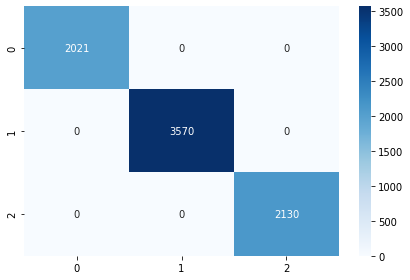

Accuracy Score on Test set : 0.99909338168631
Test Confusion matrix


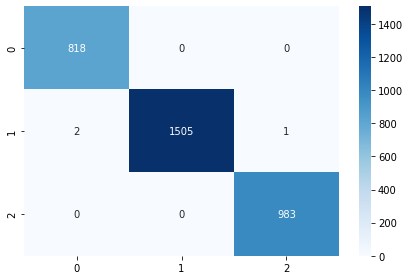

In [177]:
ensemble_clf.fit(X_train, y_train)
y_test_pred = ensemble_clf.predict(X_test)
y_train_pred = ensemble_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

#### 3.2.6.2 ExtaTreesClassifier

In [178]:
from sklearn.ensemble import ExtraTreesClassifier
ex_tree_clf = ExtraTreesClassifier(n_estimators=10, criterion="entropy", random_state=0)
k_fold_ex_tree_evaluate = cross_val_score(ex_tree_clf, x_data, y_data, cv=10)
print("k-fold evaluate for extra-trees classifier model: %0.2f" % (k_fold_ex_tree_evaluate.mean()))

k-fold evaluate for extra-trees classifier model: 1.00


Accuracy Score on Train set : 1.0
Train Confusion matrix


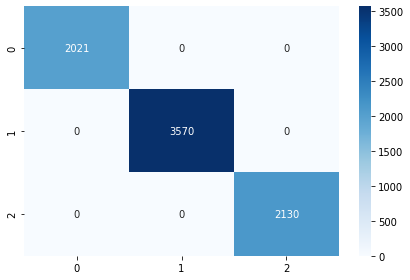

Accuracy Score on Test set : 0.9993955877908733
Test Confusion matrix


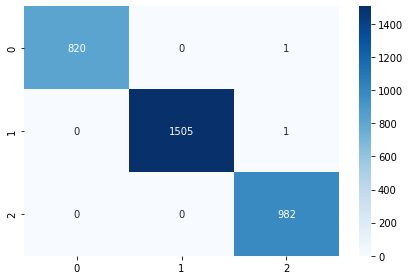

In [179]:
ex_tree_clf.fit(X_train, y_train)
y_test_pred = ex_tree_clf.predict(X_test)
y_train_pred = ex_tree_clf.predict(X_train)
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

# 4. frequent patterns and association rules

## 4.1 freq. patterns using apriori

In [180]:
coaches_for_model = pd.read_csv("coaches_dataframe.csv")
medals_for_model = pd.read_csv("medals_dataframe.csv")
teams_for_model = pd.read_csv("teams_dataframe.csv")
athletes_for_model = pd.read_csv("athletes_dataframe.csv")
entries_gender_for_model = pd.read_csv("entries_gender_dataframe.csv")

In [181]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [182]:
coaches_for_model.head()

,Name,NOC,Discipline,Event,Name_numeric,NOC_numeric,Discipline_numeric,Event_numeric
0,ABDELMAGID Wael,Egypt,Football,Men,0,0,0,0
1,ABE Junya,Japan,Volleyball,Men,1,1,1,0
2,ABE Katsuhiko,Japan,Basketball,Men,2,1,2,0
3,ADAMA Cherif,Côte d'Ivoire,Football,Men,3,2,0,0
4,AGEBA Yuya,Japan,Volleyball,Men,4,1,1,0


In [183]:
medals_for_model.head()

,Rank,Team/NOC,Gold,Silver,Bronze,Total,Rank by Total,Team/NOC_numeric
0,11,Canada,7,6,11,24,11,10
1,12,Brazil,7,6,8,21,12,11
2,13,New Zealand,7,6,7,20,13,12
3,14,Cuba,7,3,5,15,18,13
4,15,Hungary,6,7,7,20,13,14


In [184]:
teams_for_model.head()

,Name,Discipline,NOC,Event,Name_numeric,Discipline_numeric,NOC_numeric,Event_numeric
0,Belgium,3x3 Basketball,Belgium,Men,0,0,0,0
1,China,3x3 Basketball,People's Republic of China,Men,1,0,1,0
2,China,3x3 Basketball,People's Republic of China,Women,1,0,1,1
3,France,3x3 Basketball,France,Women,2,0,2,1
4,Italy,3x3 Basketball,Italy,Women,3,0,3,1


In [185]:
athletes_for_model.head()

,Name,NOC,Discipline,Name_numeric,NOC_numeric,Discipline_numeric
0,AALERUD Katrine,Norway,Cycling Road,0,0,0
1,ABAD Nestor,Spain,Artistic Gymnastics,1,1,1
2,ABAGNALE Giovanni,Italy,Rowing,2,2,2
3,ABALDE Alberto,Spain,Basketball,3,1,3
4,ABALDE Tamara,Spain,Basketball,4,1,3


In [186]:
entries_gender_for_model.head()

,Discipline,Female,Male,Total,Discipline_numeric
0,3x3 Basketball,32,32,64,0
1,Archery,64,64,128,1
2,Artistic Gymnastics,98,98,196,2
3,Artistic Swimming,105,0,105,3
4,Badminton,86,87,173,5


In [187]:
teams_for_fp = teams_for_model.drop(columns=['Name_numeric','Discipline_numeric','NOC_numeric','Event_numeric'])
teams_for_fp['Name'] = teams_for_fp['Name'].str.strip()
teams_for_fp['Discipline'] = teams_for_fp['Discipline'].str.strip()
teams_for_fp['NOC'] = teams_for_fp['NOC'].str.strip()
teams_for_fp['Event'] = teams_for_fp['Event'].str.strip()

In [188]:
coaches_for_fp = coaches_for_model.drop(columns=['Name','Name_numeric','Discipline_numeric','NOC_numeric','Event_numeric'])
coaches_for_fp['Discipline'] = coaches_for_fp['Discipline'].str.strip()
coaches_for_fp['NOC'] = coaches_for_fp['NOC'].str.strip()
coaches_for_fp['Event'] = coaches_for_fp['Event'].str.strip()

In [189]:
athletes_for_fp = athletes_for_model.drop(columns=['Name','Name_numeric','Discipline_numeric','NOC_numeric'])
# athletes_for_fp['Name'] = athletes_for_fp['Name'].str.strip()
athletes_for_fp['Discipline'] = athletes_for_fp['Discipline'].str.strip()
athletes_for_fp['NOC'] = athletes_for_fp['NOC'].str.strip()

we need to encode columns of dataframes to prepare dataframe for finding freq. patterns useing apriori algorithm

so for encode columns we used Transaction Encoder that create column for each value of columns

In [190]:
def find_frequent_patterns(dataframe, minsup = 0.1):
  te = TransactionEncoder()
  te_ary = te.fit(dataframe.values.tolist()).transform(dataframe.values.tolist())
  dataframe = pd.DataFrame(te_ary, columns=te.columns_)
  freq_patterns = apriori(dataframe, min_support= minsup, use_colnames=True)
  return freq_patterns

In [191]:
teams_for_fp['NOC'].value_counts()

Japan                       47
United States of America    43
Italy                       37
Germany                     35
Australia                   34
                            ..
Puerto Rico                  1
Chile                        1
Kenya                        1
Morocco                      1
Norway                       1
Name: NOC, Length: 61, dtype: int64

In [192]:
teams_for_japan = teams_for_fp[teams_for_fp['NOC'] == 'Japan']
teams_for_usa = teams_for_fp[teams_for_fp['NOC'] == 'United States of America']
teams_for_japan_usa = teams_for_fp[(teams_for_fp['NOC'] == 'Japan') | (teams_for_fp['NOC'] == 'United States of America')]

In [193]:
fp_of_teams_in_japan = find_frequent_patterns(teams_for_japan, 0.1)
fp_of_teams_in_japan

,support,itemsets
0,0.106383,(Fencing)
1,1.000000,(Japan)
2,0.191489,(Men)
3,0.148936,(Swimming)
4,0.191489,(Women)
5,0.106383,"(Japan, Fencing)"
6,0.191489,"(Men, Japan)"
7,0.148936,"(Swimming, Japan)"
8,0.191489,"(Japan, Women)"


In [194]:
fp_of_teams_in_usa = find_frequent_patterns(teams_for_usa, 0.2)
fp_of_teams_in_usa

,support,itemsets
0,1.0,(United States)
1,1.0,(United States of America)
2,1.0,"(United States of America, United States)"


In [195]:
fp_of_teams_in_japan_usa = find_frequent_patterns(teams_for_japan_usa, 0.2)
fp_of_teams_in_japan_usa

,support,itemsets
0,0.522222,(Japan)
1,0.477778,(United States)
2,0.477778,(United States of America)
3,0.477778,"(United States of America, United States)"


In [196]:
coaches_for_fp['NOC'].value_counts()[-50:]

Netherlands                 10
Venezuela                   10
France                      10
Nigeria                      9
Germany                      9
New Zealand                  8
Mexico                       8
Great Britain                7
Republic of Korea            7
Brazil                       7
Dominican Republic           6
Chile                        6
Greece                       6
Serbia                       5
India                        5
Côte d'Ivoire                5
Kenya                        5
Belgium                      5
Ukraine                      4
Hungary                      4
Slovenia                     3
Poland                       3
Ireland                      3
Norway                       3
Puerto Rico                  3
Sweden                       3
Austria                      3
Israel                       2
Zambia                       2
Denmark                      2
Montenegro                   2
Czech Republic               2
Saudi Ar

In [197]:
coaches_for_japan = coaches_for_fp[coaches_for_fp['NOC']=='Japan']
coaches_for_spain = coaches_for_fp[coaches_for_fp['NOC']=='Spain']
coaches_for_japan_spain = coaches_for_fp[(coaches_for_fp['NOC']=='Japan') | (coaches_for_fp['NOC']=='Spain')]
coaches_for_france = coaches_for_fp[coaches_for_fp['NOC']=='France']

In [198]:
fp_of_coaches_in_japan = find_frequent_patterns(coaches_for_japan,0.4)
fp_of_coaches_in_japan

,support,itemsets
0,1.000000,(Japan)
1,0.428571,(Men)
2,0.400000,(Women)
3,0.428571,"(Men, Japan)"
4,0.400000,"(Women, Japan)"


In [199]:
fp_of_coaches_in_spain = find_frequent_patterns(coaches_for_spain, 0.3)
fp_of_coaches_in_spain

,support,itemsets
0,0.357143,(Basketball)
1,0.357143,(Men)
2,1.000000,(Spain)
3,0.357143,(Women)
4,0.357143,"(Basketball, Spain)"
5,0.357143,"(Men, Spain)"
6,0.357143,"(Women, Spain)"


In [200]:
fp_of_coaches_in_japan_spain = find_frequent_patterns(coaches_for_japan_spain,0.3)
fp_of_coaches_in_japan_spain

,support,itemsets
0,0.555556,(Japan)
1,0.396825,(Men)
2,0.444444,(Spain)
3,0.380952,(Women)


In [201]:
fp_of_coaches_in_france = find_frequent_patterns(coaches_for_france,0.2)
fp_of_coaches_in_france

,support,itemsets
0,0.4,(Basketball)
1,0.2,(Duet)
2,1.0,(France)
3,0.2,(Handball)
4,0.4,(Men)
5,0.4,(Women)
6,0.4,"(France, Basketball)"
7,0.2,"(Women, Basketball)"
8,0.2,"(Duet, France)"
9,0.2,"(Handball, France)"


In [202]:
athletes_for_fp['NOC'].value_counts()

United States of America         615
Japan                            586
Australia                        470
People's Republic of China       401
Germany                          400
                                ... 
Bermuda                            2
Marshall Islands                   2
United Republic of Tanzania        2
Brunei Darussalam                  2
St Vincent and the Grenadines      2
Name: NOC, Length: 190, dtype: int64

In [203]:
athletes_for_fp_usa = athletes_for_fp[athletes_for_fp['NOC']=='United States of America']
athletes_for_fp_japan = athletes_for_fp[athletes_for_fp['NOC']=='Japan']
athletes_for_fp_australia = athletes_for_fp[athletes_for_fp['NOC']=='Australia']

In [204]:
fp_of_athletes_in_usa = find_frequent_patterns(athletes_for_fp_usa, 0.2)
fp_of_athletes_in_usa

,support,itemsets
0,0.234146,(Athletics)
1,1.000000,(United States of America)
2,0.234146,"(United States of America, Athletics)"


In [205]:
fp_of_athletes_in_japan = find_frequent_patterns(athletes_for_fp_japan, 0.1)
fp_of_athletes_in_japan

,support,itemsets
0,0.119454,(Athletics)
1,1.000000,(Japan)
2,0.119454,"(Athletics, Japan)"


In [206]:
fp_of_athletes_in_australia = find_frequent_patterns(athletes_for_fp_australia, 0.1)
fp_of_athletes_in_australia

,support,itemsets
0,0.138298,(Athletics)
1,1.000000,(Australia)
2,0.138298,"(Australia, Athletics)"


## 4.2 association rules

for freq. patterns in previous part, we want to find association rules and the rules with lift > 1 or lift < 1 are strong rules

In [207]:
def find_association_rules(dataframe, metric="confidence", minconf=0.6):
  rules = association_rules(dataframe, metric="confidence", min_threshold=minconf)
  return rules.head()

In [208]:
find_association_rules(fp_of_teams_in_japan)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Fencing),(Japan),0.106383,1.0,0.106383,1.0,1.0,0.0,inf
1,(Men),(Japan),0.191489,1.0,0.191489,1.0,1.0,0.0,inf
2,(Swimming),(Japan),0.148936,1.0,0.148936,1.0,1.0,0.0,inf
3,(Women),(Japan),0.191489,1.0,0.191489,1.0,1.0,0.0,inf


In [209]:
find_association_rules(fp_of_teams_in_usa)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(United States of America),(United States),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(United States),(United States of America),1.0,1.0,1.0,1.0,1.0,0.0,inf


In [210]:
find_association_rules(fp_of_teams_in_japan_usa)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(United States of America),(United States),0.477778,0.477778,0.477778,1.0,2.093023,0.249506,inf
1,(United States),(United States of America),0.477778,0.477778,0.477778,1.0,2.093023,0.249506,inf


In [211]:
find_association_rules(fp_of_coaches_in_japan)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Men),(Japan),0.428571,1.0,0.428571,1.0,1.0,0.0,inf
1,(Women),(Japan),0.400000,1.0,0.400000,1.0,1.0,0.0,inf


In [212]:
find_association_rules(fp_of_coaches_in_spain)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Basketball),(Spain),0.357143,1.0,0.357143,1.0,1.0,0.0,inf
1,(Men),(Spain),0.357143,1.0,0.357143,1.0,1.0,0.0,inf
2,(Women),(Spain),0.357143,1.0,0.357143,1.0,1.0,0.0,inf


In [213]:
find_association_rules(fp_of_coaches_in_japan_spain)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [214]:
find_association_rules(fp_of_coaches_in_france)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Basketball),(France),0.4,1.0,0.4,1.0,1.0,0.0,inf
1,(Duet),(France),0.2,1.0,0.2,1.0,1.0,0.0,inf
2,(Handball),(France),0.2,1.0,0.2,1.0,1.0,0.0,inf
3,(Men),(France),0.4,1.0,0.4,1.0,1.0,0.0,inf
4,(Women),(France),0.4,1.0,0.4,1.0,1.0,0.0,inf


In [215]:
find_association_rules(fp_of_athletes_in_usa)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Athletics),(United States of America),0.234146,1.0,0.234146,1.0,1.0,0.0,inf


In [216]:
find_association_rules(fp_of_athletes_in_japan)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Athletics),(Japan),0.119454,1.0,0.119454,1.0,1.0,0.0,inf


In [217]:
find_association_rules(fp_of_athletes_in_australia)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Athletics),(Australia),0.138298,1.0,0.138298,1.0,1.0,0.0,inf
